# Collett (2015): Survival Analysis

The following presents some survival analysis methods framed as M-estimators. The described example and methods are detailed further in the book by Collett. In survival analysis, we are commonly interested in estimating the survival or risk at a particular time. However, some observations are censored (most commonly right censored, which is exclusively considered hereafter). Therefore, our data is composed of the observation time ($T^*$) and an event indicator ($\Delta$). The observation time is usually framed as the minimum of the time-to-event ($T$) and time-to-censor ($C$). Herem we assume that each person has both times, but we only see $T^* = \min(T,C)$. The event indicator tells us which of these two options occurred ($\Delta = 1$ if it was the event). Therefore, survival analysis methods consider how to efficiently learn functions of the time-to-event variable with this partial missingness. See Collett for a more detailed review of survival analysis and its methods.

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import delicatessen as deli
from delicatessen import MEstimator
from delicatessen import data
from delicatessen.estimating_equations import ee_survival_model, ee_aft
from delicatessen.utilities import survival_predictions, aft_predictions_function

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Delicatessen version:", deli.__version__)

NumPy version:        1.25.2
SciPy version:        1.11.2
Pandas version:       1.4.1
Delicatessen version: 3.1


Here, data on the survival times of 45 women with breast cancer in Middlesex Hospital July 1987 (Table 1.2) is used. Information was collected on whether tumors were positively or negatively stained with HPA. This will be the only covariate included in the analysis.

In [2]:
times_to_predict = np.linspace(0.5, 230, 100)  # For drawing survival functions

In [3]:
d = pd.DataFrame(data.load_breast_cancer(), columns=['status', 'time', 'stain'])
d['C'] = 1
d.info()
print(d)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   status  45 non-null     int32
 1   time    45 non-null     int32
 2   stain   45 non-null     int32
 3   C       45 non-null     int64
dtypes: int32(3), int64(1)
memory usage: 1.0 KB
    status  time  stain  C
0        1    23      0  1
1        1    47      0  1
2        1    69      0  1
3        0    70      0  1
4        0    71      0  1
5        0   100      0  1
6        0   101      0  1
7        1   148      0  1
8        1   181      0  1
9        0   198      0  1
10       0   208      0  1
11       0   212      0  1
12       0   224      0  1
13       1     5      1  1
14       1     8      1  1
15       1    10      1  1
16       1    13      1  1
17       1    18      1  1
18       1    24      1  1
19       1    26      1  1
20       1    26      1  1
21       1    31      1  1
22       1    35   

Here, `time` is the observation time, `status` is the event indicator, and `stain` is whether the tumor was HPA stained positive or negative. This data set can also be loaded through `delicatessen.data.load_breast_cancer()`.

## Chapter 5: Parametric Proportional Hazards Models 

To begin, we will simply model the survival times using parametric models without covariates. 

### Exponential

The exponential model is a one parameter model that assumes the hazard is constant. It is the simplest of the survival models. This model is parameterized as 
$$ h(t) = \lambda t $$
The following code can be used to fit the exponential model

In [4]:
def psi(theta):
    return ee_survival_model(theta=theta, t=d['time'], delta=d['status'], 
                             distribution='exponential')

In [5]:
estr = MEstimator(psi, init=[0.01, ])
estr.estimate()

In [6]:
# Setting up a Table for the results
results = pd.DataFrame()
results['Params'] = ["Lambda", ]
results = results.set_index('Params')
results['Est'] = estr.theta
results['SE'] = np.diag(estr.variance) ** 0.5
ci = estr.confidence_intervals()
results['LCL'] = ci[:, 0]
results['UCL'] = ci[:, 1]

results.round(3)

,Est,SE,LCL,UCL
Params,,,,
Lambda,0.006,0.001,0.003,0.009


So the estimated hazard at each time is simply $0.006$.

Another more informative way to view the results from this model is to plot the estimated survival function. The following code generates the confidence intervals for the survival function at designated times using the Delta Method.

In [7]:
surv = survival_predictions(times=times_to_predict, 
                            theta=estr.theta, covariance=estr.variance, 
                            distribution='exponential')

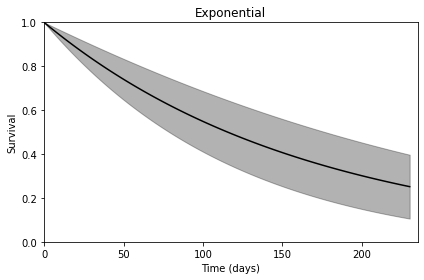

In [8]:
plt.plot(times_to_predict, surv[:, 0], '-', color='k')
plt.fill_between(times_to_predict, surv[:, 2], surv[:, 3], color='k', alpha=0.3)
plt.ylim([0, 1])
plt.ylabel("Survival")
plt.xlim([0, 235])
plt.xlabel("Time (days)")
plt.title("Exponential")
plt.tight_layout()

### Weibull 

The Weibull model is a two parameter model that is an extension of the exponential model. Here, the Weibull model is parameterized as 
$$ h(t) = \lambda \gamma t^{\gamma - 1} $$
where $\gamma$ is the shape parameter. This parameter allows for the hazard to increase or decrease monotonically. The following code is used to fit a Weibull model.

In [9]:
def psi(theta):
    return ee_survival_model(theta=theta, t=d['time'], delta=d['status'], 
                             distribution='weibull')

In [10]:
estr = MEstimator(psi, init=[0.01, 1.])
estr.estimate()

In [11]:
# Setting up a Table for the results
results = pd.DataFrame()
results['Params'] = ["Lambda", "Gamma"]
results = results.set_index('Params')
results['Est'] = estr.theta
results['SE'] = np.diag(estr.variance) ** 0.5
ci = estr.confidence_intervals()
results['LCL'] = ci[:, 0]
results['UCL'] = ci[:, 1]

results.round(3)

,Est,SE,LCL,UCL
Params,,,,
Lambda,0.010,0.005,-0.000,0.019
Gamma,0.904,0.111,0.686,1.122


Here, $\gamma$ is near 1, which suggests that the Weibull isn't much better of a fit to the data. 

As before, we can plot the survival function to get a better idea what these parameters mean

In [12]:
surv = survival_predictions(times=times_to_predict, 
                            theta=estr.theta, covariance=estr.variance, 
                            distribution='weibull')

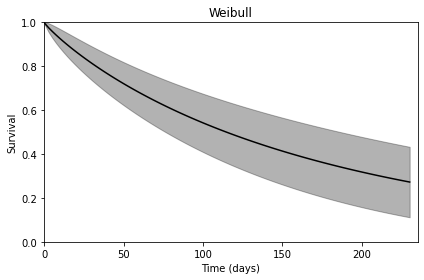

In [13]:
plt.plot(times_to_predict, surv[:, 0], '-', color='k')
plt.fill_between(times_to_predict, surv[:, 2], surv[:, 3], color='k', alpha=0.3)
plt.ylim([0, 1])
plt.ylabel("Survival")
plt.xlim([0, 235])
plt.xlabel("Time (days)")
plt.title("Weibull")
plt.tight_layout()

A disadvantage of the previous models is that they do not incorporate information on baseline covariates.

## Chapter 6: Accelerated Failure Time and Other Parametric Models

Now we will switch focus to modeling survival by baseline covariates. The following is a line-diagram which represents the follow-up time for each individual (horizontal line), their event indicator (open circles are censoring, x's are events), and the HPA stain status (shaded is negative).

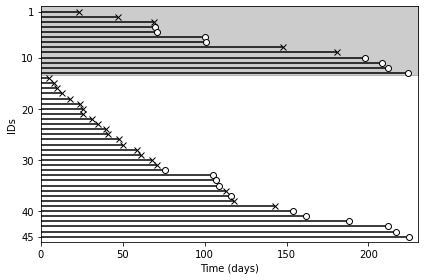

In [14]:
plt.fill_between([0, 230], [0, 0], [13.5, 13.5], alpha=0.2, color='k')
plt.hlines(d.index + 1, xmin=0, xmax=d['time'], color='k')
d1 = d.loc[d['status'] == 1].copy()
d0 = d.loc[d['status'] == 0].copy()
plt.plot(d0['time'], d0.index+1, 'o', color='w', markeredgecolor='k')
plt.plot(d1['time'], d1.index+1, 'x', color='k')
plt.xlim([0, 230])
plt.xlabel("Time (days)")
plt.ylim([46, 0])
plt.yticks([1, 10, 20, 30, 40, 45])
plt.ylabel('IDs')
plt.tight_layout()

In this case, we can see there seems to be some pattern in survival by HPA stain. However, there is censoring and our description here is pretty general. To help make our descriptions of survival differences more precise, we will use AFT models.

Here, we consider use of accelerated failure time (AFT) models with right censored data. These parametric models allow us to study how baseline variables are related to survival. AFT models are named because their scale parameters can be interpreted as how a baseline variable 'accelerates' the outcome. This acceleration is the ratio between the times when the survival are equal for a one unit change in the covariate. Alternatively, we can think about the parameters of this model as the ratio of mean survival times by covariate values.

The AFT model can be represented as a log-linear model:
$$ \log(T_i) = \beta_0 + \beta_1 X_i + \sigma \epsilon_i $$ 
where different distributions for $\epsilon$ provide different parametric AFT models. Here, $\sigma$ is the shape parameter. It will be the parameter that varies in meanining between the different parametric distributions. The $\beta$'s are the scale factors which give us the acceleration factors, which can be interpreted as "the time to death given $X=1$ is accelerated by a factor of $\exp(-\beta_1)$".

For further details on the structure and interpretation of AFT models, see the Collett book.

### Exponential

To start, we consider the exponential AFT model. The exponential AFT model assumes a constant hazard, which is likely too simple for most settings. However, it can be useful to use as a starting point. The following is code to fit this AFT model using the `ee_aft` built-in estimating equation

In [15]:
def psi(theta):
    return ee_aft(theta=theta, t=d['time'], delta=d['status'], 
                  X=d[['C', 'stain', ]], 
                  distribution='exponential')

In [16]:
estr = MEstimator(psi, init=[6., 0.])
estr.estimate()

In [17]:
# Setting up a Table for the results
results = pd.DataFrame()
results['Params'] = ["Intercept", "Stain"]
results = results.set_index('Params')
results['Est'] = estr.theta
results['SE'] = np.diag(estr.variance) ** 0.5
ci = estr.confidence_intervals()
results['LCL'] = ci[:, 0]
results['UCL'] = ci[:, 1]

results.round(3)

,Est,SE,LCL,UCL
Params,,,,
Intercept,5.800,0.431,4.956,6.645
Stain,-0.952,0.497,-1.926,0.023


Here, $\exp(0.952)$ would be the acceleration factor due to a positive HPA stain (note the cancellation of the negative signs).

Another informative way to view these results is through a plot of the survival functions. The following code computes the survival function (at user-provided time points) for a specific covariate pattern. Here, we only consider HPA stain. The next block uses these predictions (and their confidence intervals) to plot the survival functions by HPA stain.

In [18]:
surv_neg = aft_predictions_function(X=[[1, 0], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='exponential')
surv_pos = aft_predictions_function(X=[[1, 1], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='exponential')

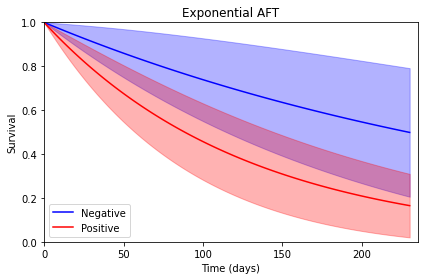

In [19]:
plt.plot(times_to_predict, surv_neg[:, 0], '-', color='blue', label='Negative')
plt.fill_between(times_to_predict, surv_neg[:, 2], surv_neg[:, 3], color='blue', alpha=0.3)
plt.plot(times_to_predict, surv_pos[:, 0], '-', color='red', label='Positive')
plt.fill_between(times_to_predict, surv_pos[:, 2], surv_pos[:, 3], color='red', alpha=0.3)
plt.ylim([0, 1])
plt.ylabel("Survival")
plt.xlim([0, 235])
plt.xlabel("Time (days)")
plt.legend()
plt.title("Exponential AFT")
plt.tight_layout()

This plot summarizes how survival unfolds over time. These plots can be helpful with interpreting or presenting results beyond the table of estimated parameters given previously.

### Weibull

The next model is the Weibull AFT model, which is a two-parameter generalization of the exponential model. In particular, it allows the hazard to vary in a specific monotonic way over time. To assess whether the exponential AFT model is reasonable, one can fit a Weibull model and assess whether the shape parameter ($\sigma$) is different from 1.

Below is how one can fit a Weibull AFT model with `ee_aft`

In [20]:
def psi(theta):
    return ee_aft(theta=theta, t=d['time'], delta=d['status'], 
                  X=d[['C', 'stain', ]], 
                  distribution='weibull')

In [21]:
estr = MEstimator(psi, init=[5., 0., 0.])
estr.estimate()

In [22]:
# Setting up a Table for the results
results = pd.DataFrame()
results['Params'] = ["Intercept", "Stain", "Shape"]
results = results.set_index('Params')
results['Est'] = estr.theta
results['SE'] = np.diag(estr.variance) ** 0.5
ci = estr.confidence_intervals()
results['LCL'] = ci[:, 0]
results['UCL'] = ci[:, 1]

results.round(3)

,Est,SE,LCL,UCL
Params,,,,
Intercept,5.854,0.483,4.909,6.800
Stain,-0.997,0.532,-2.039,0.046
Shape,-0.065,0.126,-0.311,0.182


Note that the shape parameter here is the log-transformed version, so $\exp(-0.065)$ is near one. This suggests that a Weibull AFT model provides a pretty similar fit to an exponential AFT model for this data. We can compare this to the results reported in Collett (pg 245). There we see that the intercept ($\mu$ in Collett) and stain ($\hat{\alpha}$ in Collett) match to the reported number of decimal places. Note that the $\sigma$ in `delicatessen` is the inverse of the one reported in Collett. 

Below is code to generate a plot of the survival functions. As the shape parameter is near one, this plot is expected to be similar to the exponential AFT model plot.

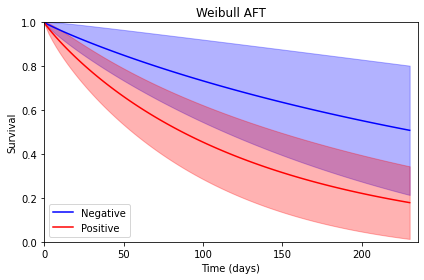

In [23]:
# Computing predictions for survival functions
surv_neg = aft_predictions_function(X=[[1, 0], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='weibull')
surv_pos = aft_predictions_function(X=[[1, 1], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='weibull')

# Plotting survival functions
plt.plot(times_to_predict, surv_neg[:, 0], '-', color='blue', label='Negative')
plt.fill_between(times_to_predict, surv_neg[:, 2], surv_neg[:, 3], color='blue', alpha=0.3)
plt.plot(times_to_predict, surv_pos[:, 0], '-', color='red', label='Positive')
plt.fill_between(times_to_predict, surv_pos[:, 2], surv_pos[:, 3], color='red', alpha=0.3)
plt.ylim([0, 1])
plt.ylabel("Survival")
plt.xlim([0, 235])
plt.xlabel("Time (days)")
plt.legend()
plt.title("Weibull AFT")
plt.tight_layout()

Other measures can also be plotted. Here, we plot the hazard functions shown in Figure 6.6 of Collett.

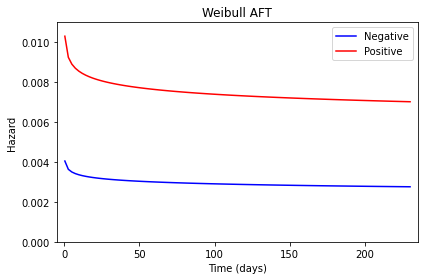

In [24]:
# Computing predictions for survival functions
haz_neg = aft_predictions_function(X=[[1, 0], ], times=times_to_predict, 
                                   theta=estr.theta, covariance=estr.variance, 
                                   distribution='weibull', measure='hazard')
haz_pos = aft_predictions_function(X=[[1, 1], ], times=times_to_predict, 
                                   theta=estr.theta, covariance=estr.variance, 
                                   distribution='weibull', measure='hazard')

# Plotting hazard functions
plt.plot(times_to_predict, haz_neg[:, 0], '-', color='blue', label='Negative')
plt.plot(times_to_predict, haz_pos[:, 0], '-', color='red', label='Positive')
plt.ylim([0, 0.011])
plt.ylabel("Hazard")
plt.xlim([-5, 235])
plt.xlabel("Time (days)")
plt.legend()
plt.title("Weibull AFT")
plt.tight_layout()

Note that the approximation near $t=0$ is less precise for the given spacing used. One could improve its appearance relative to the book by using a finer resolution.

### Log-Normal

Another option is the log-normal AFT model. The following is how `ee_aft` can be used to fit the log-normal AFT model

In [25]:
def psi(theta):
    return ee_aft(theta=theta, t=d['time'], delta=d['status'], 
                  X=d[['C', 'stain', ]], 
                  distribution='log-normal')

In [26]:
estr = MEstimator(psi, init=[5., 0., 0.])
estr.estimate()

In [27]:
# Setting up a Table for the results
results = pd.DataFrame()
results['Params'] = ["Intercept", "Stain", "Shape"]
results = results.set_index('Params')
results['Est'] = estr.theta
results['SE'] = np.diag(estr.variance) ** 0.5
ci = estr.confidence_intervals()
results['LCL'] = ci[:, 0]
results['UCL'] = ci[:, 1]

results.round(3)

,Est,SE,LCL,UCL
Params,,,,
Intercept,5.492,0.450,4.609,6.374
Stain,-1.151,0.498,-2.127,-0.176
Shape,-0.307,0.134,-0.571,-0.043


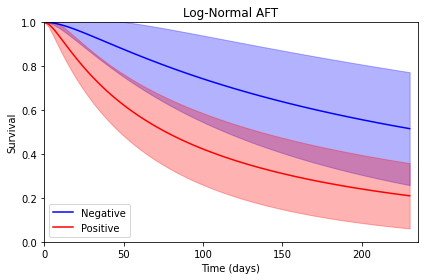

In [28]:
# Computing predictions for survival functions
surv_neg = aft_predictions_function(X=[[1, 0], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='log-normal')
surv_pos = aft_predictions_function(X=[[1, 1], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='log-normal')

# Plotting survival functions
plt.plot(times_to_predict, surv_neg[:, 0], '-', color='blue', label='Negative')
plt.fill_between(times_to_predict, surv_neg[:, 2], surv_neg[:, 3], color='blue', alpha=0.3)
plt.plot(times_to_predict, surv_pos[:, 0], '-', color='red', label='Positive')
plt.fill_between(times_to_predict, surv_pos[:, 2], surv_pos[:, 3], color='red', alpha=0.3)
plt.ylim([0, 1])
plt.ylabel("Survival")
plt.xlim([0, 235])
plt.xlabel("Time (days)")
plt.legend()
plt.title("Log-Normal AFT")
plt.tight_layout()

### Log-Logistic

The final option available in `delicatessen` is the log-logistic AFT model. The following is how `ee_aft` can be used to fit this model

In [29]:
def psi(theta):
    return ee_aft(theta=theta, t=d['time'], delta=d['status'], 
                  X=d[['C', 'stain', ]], 
                  distribution='log-logistic')

In [30]:
estr = MEstimator(psi, init=[5., 0., 0.])
estr.estimate()

In [31]:
# Setting up a Table for the results
results = pd.DataFrame()
results['Params'] = ["Intercept", "Stain", "Shape"]
results = results.set_index('Params')
results['Est'] = estr.theta
results['SE'] = np.diag(estr.variance) ** 0.5
ci = estr.confidence_intervals()
results['LCL'] = ci[:, 0]
results['UCL'] = ci[:, 1]

results.round(3)

,Est,SE,LCL,UCL
Params,,,,
Intercept,5.461,0.445,4.589,6.334
Stain,-1.149,0.505,-2.139,-0.159
Shape,0.217,0.145,-0.067,0.502


These parameter estimates are the same as those reported in Collett (except $\sigma$ due to a differing parameterization). 

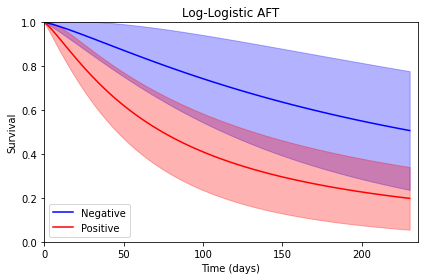

In [32]:
# Computing predictions for survival functions
surv_neg = aft_predictions_function(X=[[1, 0], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='log-logistic')
surv_pos = aft_predictions_function(X=[[1, 1], ], times=times_to_predict, 
                                    theta=estr.theta, covariance=estr.variance, 
                                    distribution='log-logistic')

# Plotting survival functions
plt.plot(times_to_predict, surv_neg[:, 0], '-', color='blue', label='Negative')
plt.fill_between(times_to_predict, surv_neg[:, 2], surv_neg[:, 3], color='blue', alpha=0.3)
plt.plot(times_to_predict, surv_pos[:, 0], '-', color='red', label='Positive')
plt.fill_between(times_to_predict, surv_pos[:, 2], surv_pos[:, 3], color='red', alpha=0.3)
plt.ylim([0, 1])
plt.ylabel("Survival")
plt.xlim([0, 235])
plt.xlabel("Time (days)")
plt.legend()
plt.title("Log-Logistic AFT")
plt.tight_layout()

Again, we can also plot the hazard functions over time and compare them to the book (Figure 6.7).

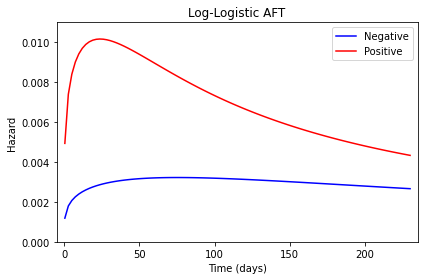

In [33]:
# Computing predictions for survival functions
haz_neg = aft_predictions_function(X=[[1, 0], ], times=times_to_predict, 
                                   theta=estr.theta, covariance=estr.variance, 
                                   distribution='log-logistic', measure='hazard')
haz_pos = aft_predictions_function(X=[[1, 1], ], times=times_to_predict, 
                                   theta=estr.theta, covariance=estr.variance, 
                                   distribution='log-logistic', measure='hazard')

# Plotting hazard functions
plt.plot(times_to_predict, haz_neg[:, 0], '-', color='blue', label='Negative')
plt.plot(times_to_predict, haz_pos[:, 0], '-', color='red', label='Positive')
# Note: the book's figure seems to have an issue. If you plot the equation given in the book,
#       (commented below), it overlaps perfectly with this output. The book's figures seem to have
#       some sort of issue? Should check against the 2023 edition when available to me.
# h1 = 1.243 * (times_to_predict)**-1 / (1 + times_to_predict**-1.243 * np.exp(6.787 - 1.428))
# plt.plot(times_to_predict, h1, '--', color='green')
# h1 = 1.243 * (times_to_predict)**-1 / (1 + times_to_predict**-1.243 * np.exp(6.787))
# plt.plot(times_to_predict, h1, '--', color='green')
plt.ylim([0, 0.011])
plt.ylabel("Hazard")
plt.xlim([-5, 235])
plt.xlabel("Time (days)")
plt.legend()
plt.title("Log-Logistic AFT")
plt.tight_layout()

Consistent with the other results, the log-logistic AFT model does not differ substantially from the other AFT models.

## Conclusion

Here, we applied some of the parametric survival models described at length in Collett using the M-estimation framework. As these models are all finite dimension parameter vectors, standard M-estimation theory straightforwardly applies. A benefit in this context is the ease that variance estimation can be accomplished to create plots with point-wise confidence intervals.

### References

Collett, D. (2015). Survival analysis. In *Modelling survival data in medical research*. 3rd Ed. Chapman and Hall/CRC. pg 6-7

Collett, D. (2015). Accelerated failure time and other parametric models. In *Modelling survival data in medical research*. 3rd Ed. Chapman and Hall/CRC. pg 221-274